# Diffusers library

In [1]:
from tqdm.auto import tqdm
import torch
from torch import autocast
import PIL.Image
import numpy as np

## Structure

The API of diffusers consists of three main blocks: 

- **Pipelines**: high-level classes designed to rapidly generate samples from popular trained diffusion models in a user-friendly fashion.
- **Models**: popular architectures for training new diffusion models, e.g. UNet.
- **Schedulers**: various techniques for generating images from noise during inference as well as to generate noisy images for training.

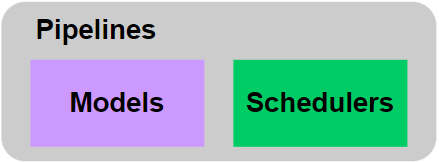

Models and schedulers are kept as independent from each other as possible:
- a scheduler should never accept a model as an input and vice-versa. 
- The model predict the noise residual or slightly less noisy image with its trained weights, while the scheduler computes the previous sample given the model's output.

## Pipeline

In [2]:
from diffusers import DDPMPipeline

# from_pretrained() downloads the model and its configuration from Hugging Face
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")

The pipeline will generate a random initial noise sample and then iterate the diffusion process.

  0%|          | 0/1000 [00:00<?, ?it/s]

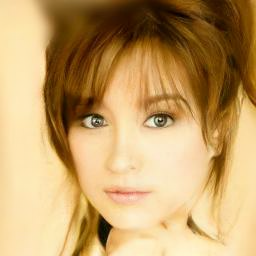

In [3]:
image_pipe.to("cuda")
images = image_pipe()["sample"]
images[0]

Let's take a look inside the pipeline

In [4]:
image_pipe

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.2.4",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

The pipeline contains the ``DDPMScheduler`` and the ``UNet2DModel`` model. Let's look at them closely.

## Models

- Instances of the model class are neural networks that take a noisy ``sample`` as well as a ``timestep`` as inputs to predict a less noisy output ``sample``.
- We'll load a simple unconditional image generation model of type ``UNet2DModel`` trained on church images

In [5]:
from diffusers import UNet2DModel

repo_id = "google/ddpm-church-256"
model = UNet2DModel.from_pretrained(repo_id)

The model is a pure PyTorch ``torch.nn.Module`` class which you can see when printing out ``model``.

In [6]:
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1

A concise description of the model configuration can be obtain from the ``config`` attribute

In [7]:
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('act_fn', 'silu'),
            ('attention_head_dim', None),
            ('norm_num_groups', 32),
            ('norm_eps', 

The model takes a random gaussian sample in the shape of an image (``batch_size``  ×  ``in_channels``  ×  ``image_size``  ×  ``image_size``).

In [8]:
noisy_sample = torch.randn(
    1, model.config.in_channels, model.config.sample_size, model.config.sample_size
)
noisy_sample.shape

torch.Size([1, 3, 256, 256])

To perform inference, we pass the noisy sample alongside a ``timestep`` through the model.

The model predicts either the slightly less noisy image, the difference between the slightly less noisy image and the input image or even something else. The information can be found in the model card.

In this case, the model predicts the noise residual $\boldsymbol{\tilde z_t}$, which has the same size of the input.

In [9]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2)["sample"]
     
noisy_residual.shape

torch.Size([1, 3, 256, 256])

The next step is to combine this model with the correct scheduler to generate actual images.

## Schedulers

- Schedulers are *algorithms* wrapped into a Python class. 
- Differently from models, schedulers have *no trainable weights*.
- They define the noise schedule which is used to add noise to the model during training, and also define the algorithm to compute the slightly less noisy sample given the model output

Run the ``from_config()`` method to load a configuration and instantiate a scheduler (note that for pipes and models we did something similar with ``from_pretrained()``).

In [10]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_config(repo_id)

Like for models, we can access the configuration of the scheduler with ``config``. 

In [11]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.2.4')])

Note:
- ``num_train_timesteps``: the length of the denoising process, e.g. how many timesteps are need to transform random gaussian noise to a data sample.
- ``beta_start`` and ``beta_end``: define the smallest and highest balues assumed by $\beta_t$
- ``beta_schedule``: define the noise changes over time, both in inference and training

All schedulers provide one or multiple ``step()`` methods that can be used to compute the slightly less noisy image. 

The ``step()`` method may vary from one scheduler to another, but normally expects:
- the model output (what we called  ``noisy_sample``)
- the ``timestep`` 
- the current ``noisy_sample``

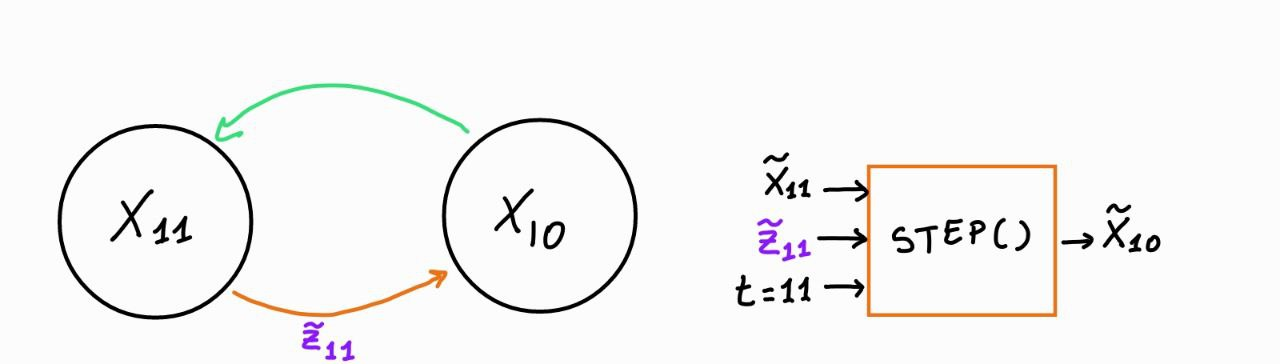

In [12]:
less_noisy_sample = scheduler.step(
    model_output=noisy_residual, timestep=13, sample=noisy_sample
)["prev_sample"]
less_noisy_sample.shape

torch.Size([1, 3, 256, 256])

**Note** some schedulers might implement ``step()`` slightly differently: always check the code/documentation of the API

Time to define the **denoising loop**.

- We loop over ``scheduler.timesteps``, a tensor defining the sequence of timesteps over which to iterate during the denoising process. 
- Usually, the denoising process goes in decreasing order of timesteps (here from 1000 to 0).
- To visualize what is going on, we print out the (less and less) noisy samples every 50 steps.

In [13]:
# define the function to visualize the images as they get denoised
def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

In [14]:
# move model and input to gpu to speed things up
model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

  0%|          | 0/1000 [00:00<?, ?it/s]

'Image at step 50'

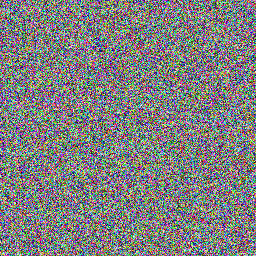

'Image at step 100'

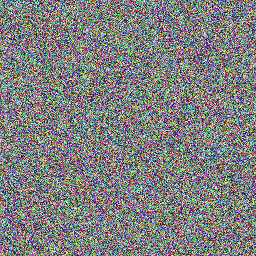

'Image at step 150'

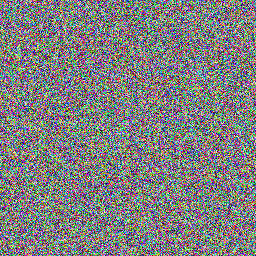

'Image at step 200'

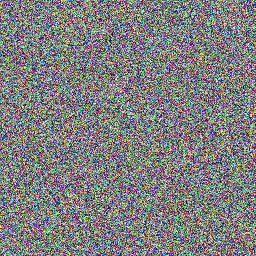

'Image at step 250'

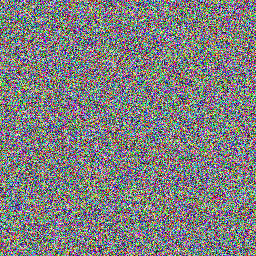

'Image at step 300'

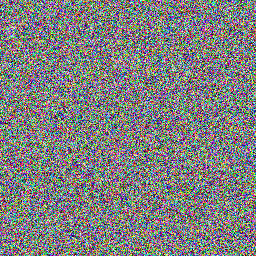

'Image at step 350'

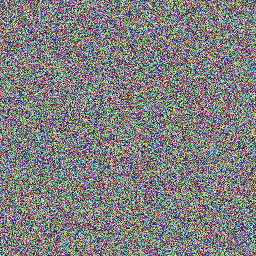

'Image at step 400'

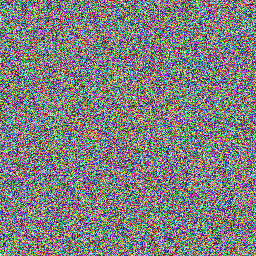

'Image at step 450'

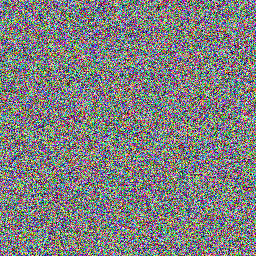

'Image at step 500'

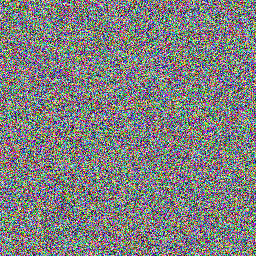

'Image at step 550'

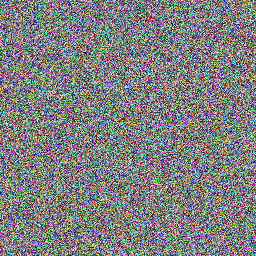

'Image at step 600'

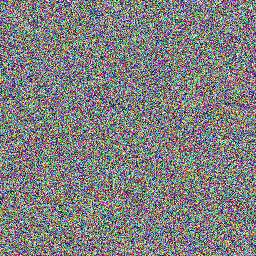

'Image at step 650'

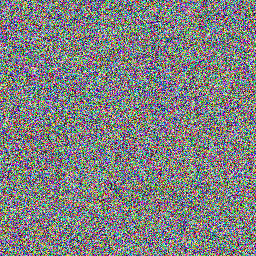

'Image at step 700'

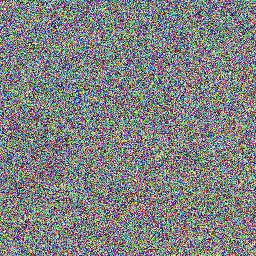

'Image at step 750'

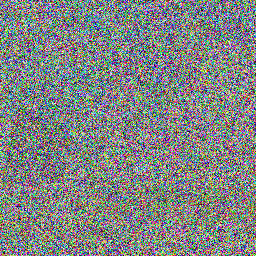

'Image at step 800'

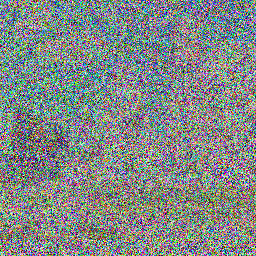

'Image at step 850'

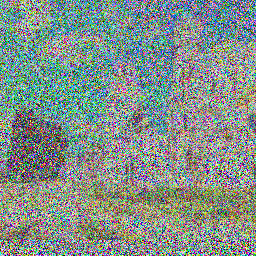

'Image at step 900'

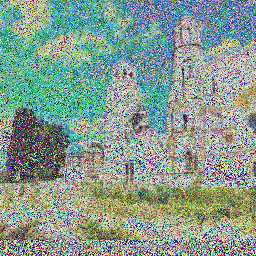

'Image at step 950'

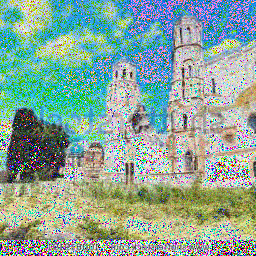

'Image at step 1000'

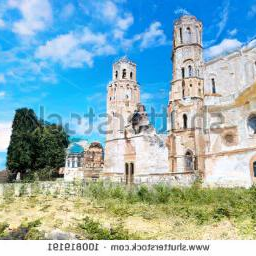

In [15]:
sample = noisy_sample # pure noise

for i, t in enumerate(tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t)["sample"]

  # 2. compute less noisy image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample)["prev_sample"]

  # 3. optionally look at image
  if (i + 1) % 50 == 0:
      display_sample(sample, i + 1)

- It takes quite some time to produce a meaningful image
- To speed-up the generation, we switch the DDPM scheduler with the DDIM scheduler
- The DDIM scheduler removes stochasticity during sampling and updates the samples every $T/S$ steps, reducing the total number of inference steps from $T$ to $S$
- Note that some schedulers follow different protocols and cannot be switched so easily like in this case

In [16]:
from diffusers import DDIMScheduler

scheduler = DDIMScheduler.from_config(repo_id)

{'timestep_values', 'set_alpha_to_one'} was not found in config. Values will be initialized to default values.


- The DDIM scheduler allows the user specify the number of inference steps $S$
- In this case, we set $S=50$ through the variable ``num_inference_steps`` 

In [17]:
scheduler.set_timesteps(num_inference_steps=50)

  0%|          | 0/50 [00:00<?, ?it/s]

'Image at step 10'

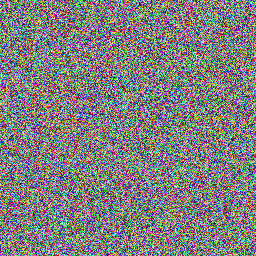

'Image at step 20'

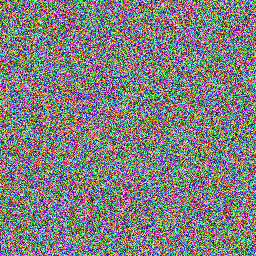

'Image at step 30'

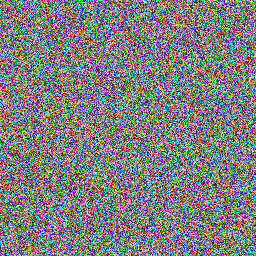

'Image at step 40'

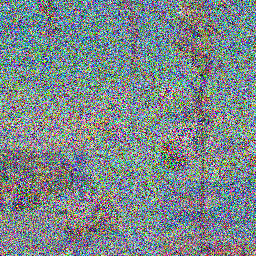

'Image at step 50'

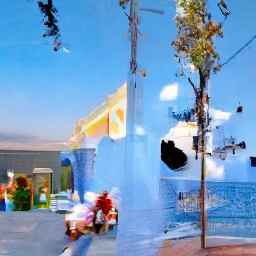

In [18]:
sample = noisy_sample

for i, t in enumerate(tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t)["sample"]

  # 2. compute previous image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample)["prev_sample"]

  # 3. optionally look at image
  if (i + 1) % 10 == 0:
      display_sample(sample, i + 1)

- In DDPM some noise with variance $\sigma_t$ (or $\tilde \beta_t$) is added to get the next sample
- Instead, the DDIM scheduler is deterministic
- Starting from the same input $x_t$ gives the same output $x_0$

## Stable Diffusion

- Stable Diffusion is based on a particular type of diffusion model called *Latent Diffusion*
- Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a **lower dimensional latent space**, instead of using the actual pixel space

There are 3 main components in the latent diffusion model.

1. The U-Net (as in DDPM/DDIM)
2. An autoencoder (VAE)
3. A text-encoder (CLIP)

- The **text-encoder** is responsible for transforming an input prompt into an embedding space that can be understood by the U-Net 
- It is usually a simple transformer-based encoder that maps a sequence of tokens (generated with a **tokenizer**) into a sequence of latent text-embeddings
- Stable Diffusion does not train the text-encoder and simply uses an already trained text encoder such as CLIP or BERT

The VAE model has two parts:
- the **encoder** is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net
- the **decoder** transforms the latent representation back into an image.
- During **training**, the encoder is used to get the latent representations of the images for the forward diffusion process 
- During **inference**, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder
- Working with latens is the key of the speed and memory efficiency of Stable Diffusion
- The VAE reduces the input size by a factor of 8

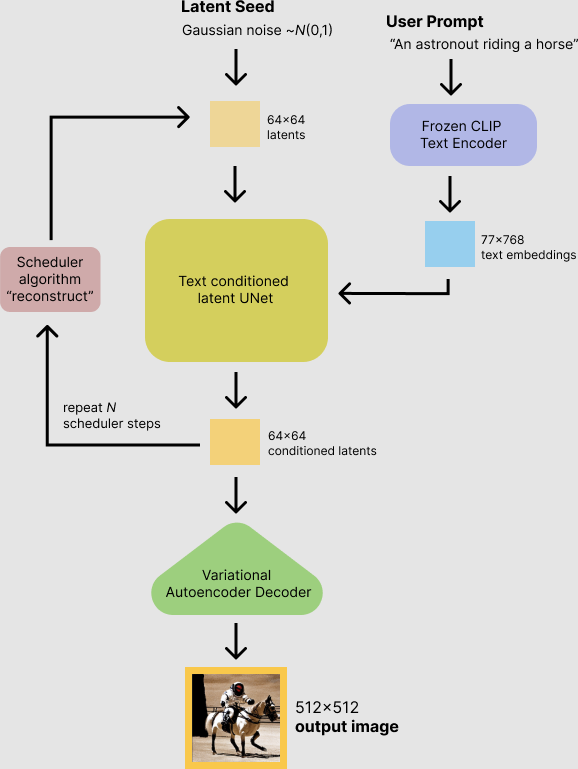

### Pre-built pipeline

Has 5 components:
- ``scheduler``: scheduling algorithm used to progressively add noise to the image during training.
- ``text_encoder``: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as BERT.
- ``tokenizer``: it must match the one used by the text_encoder model.
- ``unet``: model used to generate the latent representation of the input.
- ``vae``: module used to decode latent representations into real images.

In [19]:
with open("/home/filippo/hugging_face_token.txt","r") as f:
    token = f.read()

In [20]:
from diffusers import StableDiffusionPipeline

image_pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_auth_token=token)
image_pipe.to("cuda")

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.2.4",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Let's try it out.

0it [00:00, ?it/s]

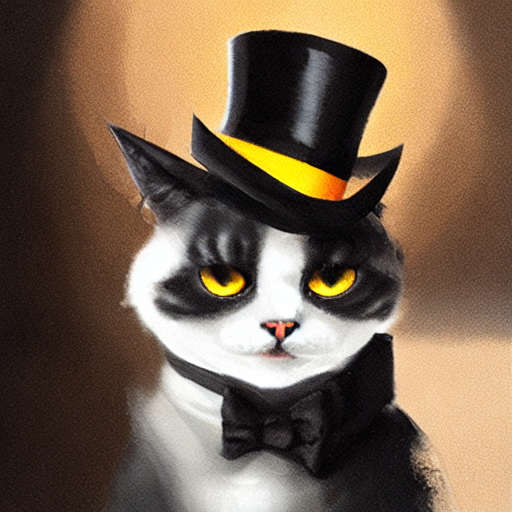

In [67]:
prompt = "A cat wearing a top hat. sharp, rendered in unreal engine 5, digital art, by greg rutkowski, dramatic lighting"
image = image_pipe(prompt,  
                   guidance_scale=7.5, 
                   num_inference_steps=50, 
                   generator=torch.Generator("cuda").manual_seed(0),
                   height=512, 
                   width=512)["sample"][0]
image

- ``guidance_scale`` forces the generation to better match the prompt potentially at the cost of image quality or diversity. Values between 7 and 8.5 are usually good choices
- ``num_inference_steps`` specifies how many denoising steps are done to generate an image. Lower values makes image generation faster but reduces quality

## Custom pipeline

- As we did before, we will replace the ``scheduler`` in the pre-built pipeline.
- The other 4 components, ``vae``, ``tokenizer``, ``text_encoder``, and ``unet`` are not changed but they could be switched as well (e.g., the CLIP ``text_encoder`` with BERT or a different type of ``vae``)
- We start by loading them

In [22]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=token)

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=token)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.17.self_attn.q_proj.weight', 'vision_model.encoder.layers.0.layer_norm1.weight', 'vision_model.encoder.layers.16.self_attn.q_proj.weight', 'vision_model.encoder.layers.1.self_attn.k_proj.weight', 'vision_model.encoder.layers.3.self_attn.v_proj.bias', 'vision_model.encoder.layers.1.layer_norm2.weight', 'vision_model.encoder.layers.13.layer_norm1.bias', 'vision_model.encoder.layers.0.mlp.fc1.bias', 'vision_model.encoder.layers.7.self_attn.out_proj.bias', 'vision_model.encoder.layers.23.self_attn.k_proj.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.bias', 'vision_model.encoder.layers.13.mlp.fc2.weight', 'vision_model.encoder.layers.6.self_attn.k_proj.weight', 'vision_model.encoder.layers.19.self_attn.out_proj.weight', 'vision_model.encoder.layers.10.self_attn.q_proj.bias', 'vision_model.encoder.layers.9.self_attn.out_proj.weight', 'vis

Next, we load the *K-LMS* scheduler instead of the *PNDMScheduler* from the default pipeline

In [23]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [24]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device) 

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): SpatialTransformer(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (attn1): CrossAttention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_features=320, bias=False)
                (to_out): Sequential(
                

**Hyperparameters**

In [68]:
prompt = ["A cat wearing a top hat. sharp, rendered in unreal engine 5, digital art, by greg rutkowski, dramatic lighting"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
generator = torch.manual_seed(0)    # Use the same random seed as before
guidance_scale = 7.5                # Scale for classifier-free guidance
num_inference_steps = 100           # Number of denoising steps

**Text embeddings** 

- First, we get the embeddings for the prompt
- These embeddings will be used to condition the UNet model and guide the image generation towards something that should resemble the input prompt
- The text_embeddings are arrays of size $77 \times 768$

In [69]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

text_embeddings.shape

torch.Size([1, 77, 768])

- We'll also get the unconditional text embeddings for classifier-free guidance, which are just the embeddings for the empty text ``""``

In [70]:
uncond_input = tokenizer([""], padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")

uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]  

text_embeddings.shape

torch.Size([1, 77, 768])

**Guidance**

For classifier-free guidance, we need to do two forward passes: 
- one with the conditioned input (``text_embeddings``) to get $\tilde z_{x|y}$ (i.e., the score function $\nabla_x p(x|y)$)
- one with the unconditional embeddings (``uncond_embeddings``) to get $\tilde z_x$ (i.e., the score function $\nabla_x p(x)$)

In practice, we can concatenate both into a single batch to avoid doing two forward passes

The final predicted noise is $\tilde z = \tilde z_x + \gamma \big( \tilde z_{x|y} - \tilde z_x \big)$

In [71]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

**Initial random noise**

- Stable Diffusion takes denoising in the latent space, which is $8$ times smaller than the input space ($64 \times 64$ vs. $512 \times 512$)

In [72]:
latents = torch.randn(
    (1, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)
latents.shape

torch.Size([1, 4, 64, 64])

**Scheduler**

- We initialize the *K-LMS* with the ``num_inference_steps`` hyperparameter 
- The scheduler will compute the sigmas $\sigma_t$ to be used during the denoising process
- *K-LMS* computes the next latent to be fed in the U-net as $\tilde x_t = \frac{\tilde x_t}{\sqrt{\sigma_t^2 +1}}$

In [73]:
# Denoise loop
scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.sigmas[0]

with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

0it [00:00, ?it/s]

In [74]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
image = vae.decode(latents)

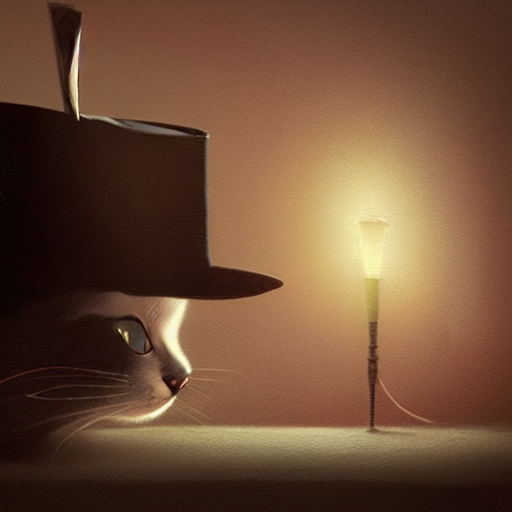

In [75]:
# visualize the image
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [PIL.Image.fromarray(image) for image in images]
pil_images[0]

## Evaluation metrics

There are two metrics commonly used to evaluate the performance of a generative model:
- the Frechet Inception Distance (FID)
- the CLIP score

**Frechet Inception Distance (FID)**

- Take a sample of generated images, feed them into a pre-trained Inception v3 model, and take the outputs from the last pooling layer (a feature vector of size 2,048)
- Do the same with real images
- The result is two collections of 2,048 feature vectors for real and generated images
- The two collections are summarized by two multivariate Gaussians $\mathcal{N}(\mu_1, C_1)$ and $\mathcal{N}(\mu_2, C_2)$
- $\mu_1$ and $\mu_2$ are the means of the two collections of vectors
- $C_1$ and $C_2$ are the covariance matrices
- FID computes the dissimilarity between the two Gaussians as
$$
\lvert \mu_1 – \mu_2\rvert^2 + \text{Tr}\left(C_1 + C_2 – 2\sqrt{C_1*C_2}\right)
$$

- A low FID indicates a good match between real and generated images

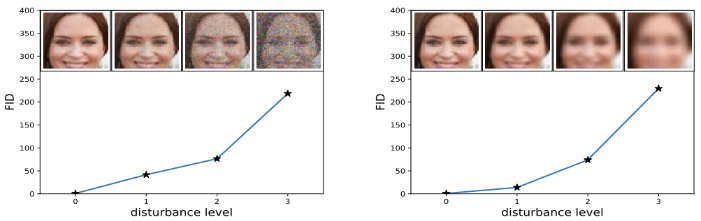


**CLIP score**

- CLIP is a multi-modal vision and language model 
- It can return the best caption given an image and has impressive zero-shot capabilities
- CLIP uses a ViT like transformer to get visual features 
- CLIP uses a causal language model (predicts the token after a sequence of tokens) to get the text features 
- Both the text and visual features are projected to a latent space with identical dimension
- The dot product between the projected image and text features can be used as a similar score
- A CLIP score quantifies the adherence of a generated image to the text prompt

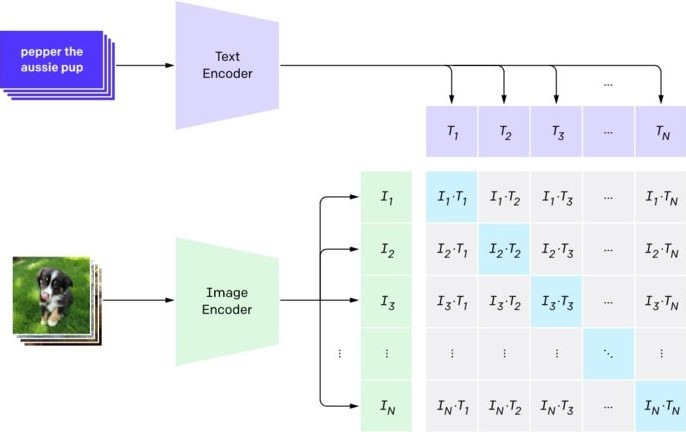

Performance of different Stable Diffusion checkpoints

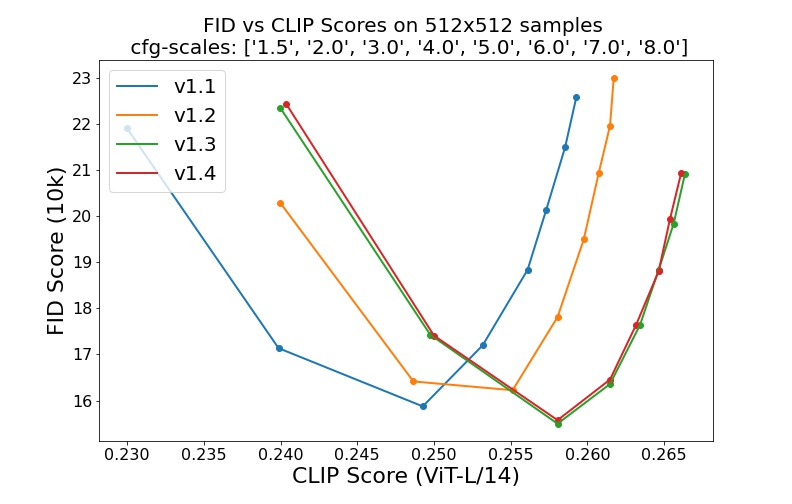